# 02 – Threshold, CNN/LSTM/TCN, Larger Window (512) – **Test Includes Positives**

This notebook matches the **real test** requirement:
- **Train:** B0005
- **Validation:** B0006
- **Test:** B0018 
Notes:
- We preprocess all 4 batteries to build `processed.parquet`.
- We exclude B0007 from the main split because it has 0 positives (use only for optional false-alarm checks).


In [1]:
from src import config
print('DATA_DIR =', config.DATA_DIR)
print('WINDOWS_DIR =', config.WINDOWS_DIR)
print('RUNS_DIR =', config.RUNS_DIR)
print('Default WIN =', config.WIN)
print('Default STRIDE =', config.STRIDE)


DATA_DIR = C:\Users\Sobhi\OneDrive\Documents\ece5831-2025-assignments\Project\Data\battery_data
WINDOWS_DIR = C:\Users\Sobhi\OneDrive\Documents\ece5831-2025-assignments\Project\Data\windows
RUNS_DIR = C:\Users\Sobhi\OneDrive\Documents\ece5831-2025-assignments\Project\runs
Default WIN = 256
Default STRIDE = 64


## 0) Preprocess
Loads `.mat` files and writes `Data/processed.parquet`.


In [2]:
from src import preprocess
preprocess.main()

[preprocess] wrote C:\Users\Sobhi\OneDrive\Documents\ece5831-2025-assignments\Project\Data\processed.parquet rows=185721
[preprocess] per-battery fault rate:
battery_id
B0005    0.2654
B0006    0.3590
B0007    0.0000
B0018    0.1690
Name: fault, dtype: float64
[preprocess] overall fault rate: 0.2008


## 1) Force split (test has positives)
This ensures all subsequent `windows/train/evaluate` runs use B0018 as the test set.


In [3]:
from src import config
config.TRAIN_BATTS = ['B0005']
config.VAL_BATTS   = ['B0006']
config.TEST_BATTS  = ['B0018']
print('TRAIN_BATTS =', config.TRAIN_BATTS)
print('VAL_BATTS   =', config.VAL_BATTS)
print('TEST_BATTS  =', config.TEST_BATTS)


TRAIN_BATTS = ['B0005']
VAL_BATTS   = ['B0006']
TEST_BATTS  = ['B0018']


## 2) WIN=256 pipeline (CNN baseline + threshold tuning + LSTM/TCN)
### 2a) Regenerate windows (WIN=256)


In [4]:
from src import windows
from src import config
config.WIN = 256
config.STRIDE = 64
print('WIN/STRIDE =', config.WIN, config.STRIDE)
windows.main()

WIN/STRIDE = 256 64
[windows] batteries by split:
  train: ['B0005']
  val:   ['B0006']
  test:  ['B0018']
train: X(782, 256, 3) y(782,)  pos=208 neg=574 pos_rate=0.2660
val: X(782, 256, 3) y(782,)  pos=286 neg=496 pos_rate=0.3657
test: X(541, 256, 3) y(541,)  pos=101 neg=440 pos_rate=0.1867


### 2b) Train CNN1D (WIN=256)
Trains a fresh model under the test-positive split so threshold tuning and comparisons are consistent.


In [5]:
from src import train
from src import config
import sys

run256 = (config.RUNS_DIR / 'cnn1d_testpos_win256').as_posix()
sys.argv = ['train', '--model','cnn1d','--epochs','10','--out', run256]
train.main()

Epoch 1/10: 100%|██████████| 13/13 [00:00<00:00, 88.86it/s]


[val] epoch=1 loss=0.6300 AP=0.390 P=0.000 R=0.000 F1=0.000


Epoch 2/10: 100%|██████████| 13/13 [00:00<00:00, 92.58it/s]


[val] epoch=2 loss=0.5631 AP=0.734 P=0.000 R=0.000 F1=0.000


Epoch 3/10: 100%|██████████| 13/13 [00:00<00:00, 89.94it/s]


[val] epoch=3 loss=0.5137 AP=0.802 P=1.000 R=0.087 F1=0.161


Epoch 4/10: 100%|██████████| 13/13 [00:00<00:00, 103.69it/s]


[val] epoch=4 loss=0.4680 AP=0.841 P=0.844 R=0.434 F1=0.573


Epoch 5/10: 100%|██████████| 13/13 [00:00<00:00, 100.88it/s]


[val] epoch=5 loss=0.4185 AP=0.865 P=0.843 R=0.580 F1=0.687


Epoch 6/10: 100%|██████████| 13/13 [00:00<00:00, 95.82it/s]


[val] epoch=6 loss=0.3651 AP=0.887 P=0.775 R=0.832 F1=0.803


Epoch 7/10: 100%|██████████| 13/13 [00:00<00:00, 91.74it/s]


[val] epoch=7 loss=0.3367 AP=0.901 P=0.769 R=0.825 F1=0.796


Epoch 8/10: 100%|██████████| 13/13 [00:00<00:00, 102.40it/s]


[val] epoch=8 loss=0.3043 AP=0.909 P=0.749 R=0.846 F1=0.795


Epoch 9/10: 100%|██████████| 13/13 [00:00<00:00, 95.56it/s]


[val] epoch=9 loss=0.2809 AP=0.914 P=0.810 R=0.818 F1=0.814


Epoch 10/10: 100%|██████████| 13/13 [00:00<00:00, 101.21it/s]


[val] epoch=10 loss=0.2564 AP=0.917 P=0.777 R=0.843 F1=0.809
Saved best to: C:/Users/Sobhi/OneDrive/Documents/ece5831-2025-assignments/Project/runs/cnn1d_testpos_win256/best.pt


### 2c) Threshold tuning (on validation = B0006)


In [6]:
from src import thresholds
from src import config
import sys

ckpt = (config.RUNS_DIR / 'cnn1d_testpos_win256' / 'best.pt').as_posix()
sys.argv = ['thresholds', '--ckpt', ckpt]
thresholds.main()


[Threshold Tuning]
Best threshold: 0.5857
Best F1 score: 0.8137
Saved threshold to: C:\Users\Sobhi\OneDrive\Documents\ece5831-2025-assignments\Project\runs\best_threshold.txt


### 2d) Train LSTM and TCN (WIN=256)


In [7]:
from src import train
from src import config
import sys

sys.argv = ['train', '--model','lstm','--epochs','10', '--out', (config.RUNS_DIR / 'lstm_testpos_win256').as_posix()]
train.main()

sys.argv = ['train', '--model','tcn','--epochs','10', '--out', (config.RUNS_DIR / 'tcn_testpos_win256').as_posix()]
train.main()

Epoch 1/10: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


[val] epoch=1 loss=0.6774 AP=0.482 P=0.000 R=0.000 F1=0.000


Epoch 2/10: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


[val] epoch=2 loss=0.6173 AP=0.525 P=0.000 R=0.000 F1=0.000


Epoch 3/10: 100%|██████████| 13/13 [00:00<00:00, 13.94it/s]


[val] epoch=3 loss=0.5848 AP=0.527 P=0.000 R=0.000 F1=0.000


Epoch 4/10: 100%|██████████| 13/13 [00:00<00:00, 13.83it/s]


[val] epoch=4 loss=0.5712 AP=0.539 P=0.000 R=0.000 F1=0.000


Epoch 5/10: 100%|██████████| 13/13 [00:00<00:00, 13.71it/s]


[val] epoch=5 loss=0.5691 AP=0.556 P=0.000 R=0.000 F1=0.000


Epoch 6/10: 100%|██████████| 13/13 [00:00<00:00, 13.98it/s]


[val] epoch=6 loss=0.5671 AP=0.561 P=0.000 R=0.000 F1=0.000


Epoch 7/10: 100%|██████████| 13/13 [00:00<00:00, 13.52it/s]


[val] epoch=7 loss=0.5650 AP=0.563 P=1.000 R=0.080 F1=0.149


Epoch 8/10: 100%|██████████| 13/13 [00:01<00:00, 12.98it/s]


[val] epoch=8 loss=0.5607 AP=0.581 P=1.000 R=0.066 F1=0.125


Epoch 9/10: 100%|██████████| 13/13 [00:00<00:00, 14.11it/s]


[val] epoch=9 loss=0.5596 AP=0.580 P=0.865 R=0.112 F1=0.198


Epoch 10/10: 100%|██████████| 13/13 [00:00<00:00, 17.64it/s]


[val] epoch=10 loss=0.5519 AP=0.594 P=0.825 R=0.115 F1=0.202
Saved best to: C:/Users/Sobhi/OneDrive/Documents/ece5831-2025-assignments/Project/runs/lstm_testpos_win256/best.pt


Epoch 1/10: 100%|██████████| 13/13 [00:00<00:00, 86.25it/s]


[val] epoch=1 loss=0.6385 AP=0.280 P=0.000 R=0.000 F1=0.000


Epoch 2/10: 100%|██████████| 13/13 [00:00<00:00, 71.57it/s]


[val] epoch=2 loss=0.5765 AP=0.732 P=0.000 R=0.000 F1=0.000


Epoch 3/10: 100%|██████████| 13/13 [00:00<00:00, 89.46it/s]


[val] epoch=3 loss=0.5321 AP=0.814 P=0.000 R=0.000 F1=0.000


Epoch 4/10: 100%|██████████| 13/13 [00:00<00:00, 102.82it/s]


[val] epoch=4 loss=0.4891 AP=0.845 P=1.000 R=0.199 F1=0.332


Epoch 5/10: 100%|██████████| 13/13 [00:00<00:00, 90.00it/s]

[val] epoch=5 loss=0.4445 AP=0.873 P=0.843 R=0.563 F1=0.675



Epoch 6/10: 100%|██████████| 13/13 [00:00<00:00, 104.53it/s]


[val] epoch=6 loss=0.3938 AP=0.892 P=0.855 R=0.724 F1=0.784


Epoch 7/10: 100%|██████████| 13/13 [00:00<00:00, 114.12it/s]


[val] epoch=7 loss=0.3509 AP=0.904 P=0.757 R=0.860 F1=0.805


Epoch 8/10: 100%|██████████| 13/13 [00:00<00:00, 118.22it/s]


[val] epoch=8 loss=0.3181 AP=0.910 P=0.786 R=0.822 F1=0.803


Epoch 9/10: 100%|██████████| 13/13 [00:00<00:00, 112.80it/s]


[val] epoch=9 loss=0.2866 AP=0.915 P=0.805 R=0.825 F1=0.815


Epoch 10/10: 100%|██████████| 13/13 [00:00<00:00, 107.68it/s]


[val] epoch=10 loss=0.2627 AP=0.916 P=0.743 R=0.881 F1=0.806
Saved best to: C:/Users/Sobhi/OneDrive/Documents/ece5831-2025-assignments/Project/runs/tcn_testpos_win256/best.pt


### 2e) Evaluate CNN (WIN=256) on test=B0018


Wrote plots & metrics to C:/Users/Sobhi/OneDrive/Documents/ece5831-2025-assignments/Project/runs/cnn1d_testpos_win256


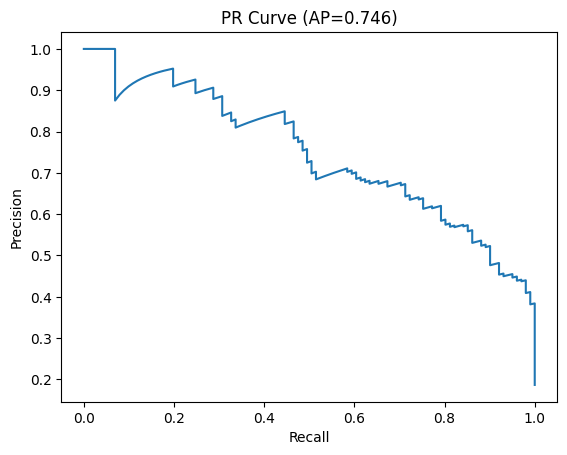

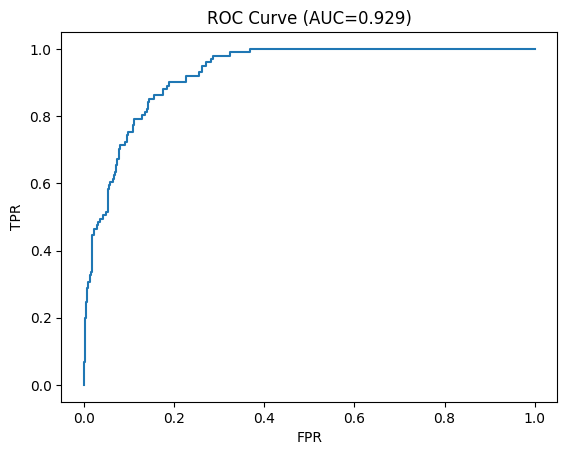

In [8]:
from src import evaluate
from src import config
import sys

ckpt = (config.RUNS_DIR / 'cnn1d_testpos_win256' / 'best.pt').as_posix()
out_dir = (config.RUNS_DIR / 'cnn1d_testpos_win256').as_posix()
sys.argv = ['evaluate', '--ckpt', ckpt, '--out', out_dir]
evaluate.main()

## 3) WIN=512 pipeline (CNN/LSTM/TCN) – SAME split
We keep Train/Val/Test batteries the same and only change WIN/STRIDE.


In [9]:
from src import windows
from src import config

config.WIN = 512
config.STRIDE = 128
print('WIN/STRIDE =', config.WIN, config.STRIDE)
windows.main()

WIN/STRIDE = 512 128
[windows] batteries by split:
  train: ['B0005']
  val:   ['B0006']
  test:  ['B0018']
train: X(389, 512, 3) y(389,)  pos=104 neg=285 pos_rate=0.2674
val: X(389, 512, 3) y(389,)  pos=143 neg=246 pos_rate=0.3676
test: X(269, 512, 3) y(269,)  pos=54 neg=215 pos_rate=0.2007


### 3a) Train CNN1D/LSTM/TCN (WIN=512)


In [10]:
from src import train as train_module
from src import config
import sys

sys.argv = ['train', '--model','cnn1d','--epochs','10', '--out', (config.RUNS_DIR / 'cnn1d_testpos_win512').as_posix()]
train_module.main()

sys.argv = ['train', '--model','lstm','--epochs','10', '--out', (config.RUNS_DIR / 'lstm_testpos_win512').as_posix()]
train_module.main()

sys.argv = ['train', '--model','tcn','--epochs','10', '--out', (config.RUNS_DIR / 'tcn_testpos_win512').as_posix()]
train_module.main()

Epoch 1/10: 100%|██████████| 7/7 [00:00<00:00, 53.86it/s]


[val] epoch=1 loss=0.6292 AP=0.371 P=0.000 R=0.000 F1=0.000


Epoch 2/10: 100%|██████████| 7/7 [00:00<00:00, 43.36it/s]


[val] epoch=2 loss=0.5795 AP=0.701 P=0.000 R=0.000 F1=0.000


Epoch 3/10: 100%|██████████| 7/7 [00:00<00:00, 49.90it/s]


[val] epoch=3 loss=0.5591 AP=0.795 P=0.000 R=0.000 F1=0.000


Epoch 4/10: 100%|██████████| 7/7 [00:00<00:00, 60.70it/s]


[val] epoch=4 loss=0.5433 AP=0.861 P=0.000 R=0.000 F1=0.000


Epoch 5/10: 100%|██████████| 7/7 [00:00<00:00, 59.52it/s]


[val] epoch=5 loss=0.5131 AP=0.902 P=0.000 R=0.000 F1=0.000


Epoch 6/10: 100%|██████████| 7/7 [00:00<00:00, 58.98it/s]


[val] epoch=6 loss=0.4892 AP=0.915 P=1.000 R=0.042 F1=0.081


Epoch 7/10: 100%|██████████| 7/7 [00:00<00:00, 61.69it/s]


[val] epoch=7 loss=0.4588 AP=0.933 P=0.985 R=0.469 F1=0.635


Epoch 8/10: 100%|██████████| 7/7 [00:00<00:00, 62.02it/s]


[val] epoch=8 loss=0.4253 AP=0.937 P=0.986 R=0.510 F1=0.673


Epoch 9/10: 100%|██████████| 7/7 [00:00<00:00, 53.71it/s]


[val] epoch=9 loss=0.3874 AP=0.939 P=0.940 R=0.657 F1=0.774


Epoch 10/10: 100%|██████████| 7/7 [00:00<00:00, 54.12it/s]


[val] epoch=10 loss=0.3482 AP=0.940 P=0.812 R=0.874 F1=0.842
Saved best to: C:/Users/Sobhi/OneDrive/Documents/ece5831-2025-assignments/Project/runs/cnn1d_testpos_win512/best.pt


Epoch 1/10: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


[val] epoch=1 loss=0.6665 AP=0.505 P=0.000 R=0.000 F1=0.000


Epoch 2/10: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


[val] epoch=2 loss=0.6283 AP=0.524 P=0.000 R=0.000 F1=0.000


Epoch 3/10: 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]


[val] epoch=3 loss=0.5958 AP=0.521 P=0.000 R=0.000 F1=0.000


Epoch 4/10: 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


[val] epoch=4 loss=0.5755 AP=0.544 P=0.000 R=0.000 F1=0.000


Epoch 5/10: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]


[val] epoch=5 loss=0.5788 AP=0.482 P=0.000 R=0.000 F1=0.000


Epoch 6/10: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]


[val] epoch=6 loss=0.5713 AP=0.517 P=0.000 R=0.000 F1=0.000


Epoch 7/10: 100%|██████████| 7/7 [00:17<00:00,  2.54s/it]


[val] epoch=7 loss=0.5728 AP=0.523 P=0.000 R=0.000 F1=0.000


Epoch 8/10: 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]


[val] epoch=8 loss=0.5705 AP=0.529 P=0.000 R=0.000 F1=0.000


Epoch 9/10: 100%|██████████| 7/7 [00:10<00:00,  1.54s/it]


[val] epoch=9 loss=0.5730 AP=0.513 P=0.000 R=0.000 F1=0.000


Epoch 10/10: 100%|██████████| 7/7 [00:09<00:00,  1.40s/it]


[val] epoch=10 loss=0.5681 AP=0.503 P=0.000 R=0.000 F1=0.000
Saved best to: C:/Users/Sobhi/OneDrive/Documents/ece5831-2025-assignments/Project/runs/lstm_testpos_win512/best.pt


Epoch 1/10: 100%|██████████| 7/7 [00:00<00:00, 41.06it/s]


[val] epoch=1 loss=0.7358 AP=0.225 P=0.000 R=0.000 F1=0.000


Epoch 2/10: 100%|██████████| 7/7 [00:00<00:00, 42.57it/s]


[val] epoch=2 loss=0.6651 AP=0.230 P=0.000 R=0.000 F1=0.000


Epoch 3/10: 100%|██████████| 7/7 [00:00<00:00, 46.61it/s]


[val] epoch=3 loss=0.6256 AP=0.242 P=0.000 R=0.000 F1=0.000


Epoch 4/10: 100%|██████████| 7/7 [00:00<00:00, 50.58it/s]

[val] epoch=4 loss=0.6084 AP=0.297 P=0.000 R=0.000 F1=0.000



Epoch 5/10: 100%|██████████| 7/7 [00:00<00:00, 35.03it/s]


[val] epoch=5 loss=0.5946 AP=0.472 P=0.000 R=0.000 F1=0.000


Epoch 6/10: 100%|██████████| 7/7 [00:00<00:00, 38.95it/s]


[val] epoch=6 loss=0.5803 AP=0.659 P=0.000 R=0.000 F1=0.000


Epoch 7/10: 100%|██████████| 7/7 [00:00<00:00, 26.02it/s]


[val] epoch=7 loss=0.5672 AP=0.739 P=0.000 R=0.000 F1=0.000


Epoch 8/10: 100%|██████████| 7/7 [00:00<00:00, 37.38it/s]


[val] epoch=8 loss=0.5528 AP=0.781 P=0.000 R=0.000 F1=0.000


Epoch 9/10: 100%|██████████| 7/7 [00:00<00:00, 48.32it/s]


[val] epoch=9 loss=0.5385 AP=0.809 P=0.000 R=0.000 F1=0.000


Epoch 10/10: 100%|██████████| 7/7 [00:00<00:00, 45.38it/s]


[val] epoch=10 loss=0.5260 AP=0.838 P=0.000 R=0.000 F1=0.000
Saved best to: C:/Users/Sobhi/OneDrive/Documents/ece5831-2025-assignments/Project/runs/tcn_testpos_win512/best.pt


### 3b) Evaluate CNN (WIN=512) on test=B0018


Wrote plots & metrics to C:/Users/Sobhi/OneDrive/Documents/ece5831-2025-assignments/Project/runs/cnn1d_testpos_win512


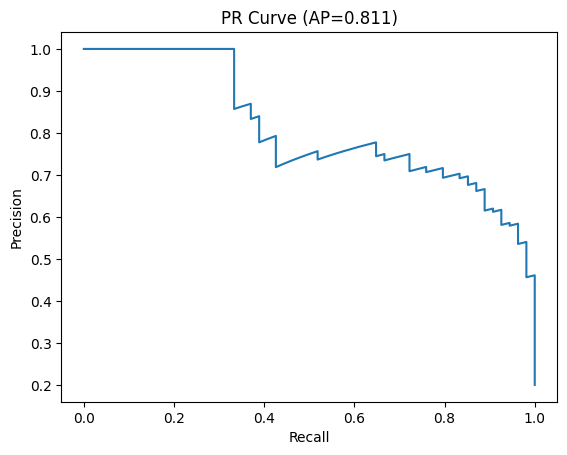

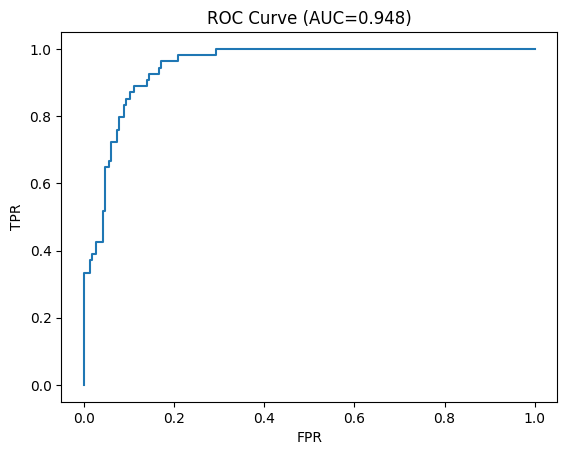

In [11]:
from src import evaluate
from src import config
import sys

ckpt = (config.RUNS_DIR / 'cnn1d_testpos_win512' / 'best.pt').as_posix()
out_dir = (config.RUNS_DIR / 'cnn1d_testpos_win512').as_posix()
sys.argv = ['evaluate', '--ckpt', ckpt, '--out', out_dir]
evaluate.main()

## Optional: False-alarm check (B0007)
Run separately if you want to report false-positive rate on an all-healthy battery.


In [12]:
# OPTIONAL (uncomment):
# from src import config, windows, evaluate
# import sys
# config.TEST_BATTS = ['B0007']
# windows.main()
# ckpt = (config.RUNS_DIR / 'cnn1d_testpos_win512' / 'best.pt').as_posix()
# out_dir = (config.RUNS_DIR / 'cnn1d_testpos_win512').as_posix()
# sys.argv = ['evaluate', '--ckpt', ckpt, '--out', out_dir]
# evaluate.main()